In [1]:
# !pip install alibi seaborn

In [2]:
import os 
import alibi 
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import tensorflow as tf 

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder 
from tensorflow.keras.layers import Dense, InputLayer 
from alibi_detect.od import OutlierVAE 
from alibi_detect.utils.perturbation import inject_outlier_tabular 
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score

def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)

In [3]:
adult = alibi.datasets.fetch_adult()
X, y = adult.data, adult.target
feature_names = adult.feature_names
category_map_tmp = adult.category_map
X.shape, y.shape

((32561, 12), (32561,))

In [4]:
set_seed(0)
Xy_perm = np.random.permutation(np.c_[X, y])
X, y = Xy_perm[:, :-1], Xy_perm[:, -1]

In [5]:
keep_cols = [2, 3, 5, 0, 8, 9, 10]
feature_names = feature_names[2:4] + feature_names[5:6] + feature_names[0:1] + feature_names[8:11]
print(feature_names)

['Education', 'Marital Status', 'Relationship', 'Age', 'Capital Gain', 'Capital Loss', 'Hours per week']


In [6]:
X = X[:, keep_cols]
print(X.shape)

(32561, 7)


In [7]:
category_map = {}
i = 0
for k, v in category_map_tmp.items():
    if k in keep_cols:
        category_map[i] = v 
        i += 1

In [8]:
minmax = False
X_num = X[:, -4:].astype(np.float32, copy=False)
if minmax:
    xmin, xmax = X_num.min(axis=0), X_num.max(axis=0)
    rng = (-1., -1.)
    X_num_scaled = (X_num - xmin) / (xmax - xmin) * (rng[1] - rng[0]) + rng[0]
else:
    mu, sigma = X_num.mean(axis=0), X_num.std(axis=0)
    X_num_scaled = (X_num - mu) / sigma

In [9]:
X_cat = X[:, :-4].copy()
ohe = OneHotEncoder(categories='auto')
ohe.fit(X_cat)

OneHotEncoder()

In [10]:
X = np.c_[X_cat, X_num_scaled].astype(np.float32, copy=False)

n_train = 25000 
n_valid = 5000 
X_train, y_train = X[:n_train, :], y[:n_train]
X_valid, y_valid = X[n_train:n_train + n_valid, :], y[n_train:n_train + n_valid]
X_test, y_test = X[n_train + n_valid:, :], y[n_train + n_valid:]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(25000, 7) (25000,) (5000, 7) (5000,) (2561, 7) (2561,)


### Create outliers

In [11]:
cat_cols = list(category_map.keys())
num_cols = [col for col in range(X.shape[1]) if col not in cat_cols]
print(cat_cols, num_cols)

[0, 1, 2] [3, 4, 5, 6]


In [12]:
perc_outlier = 10
data = inject_outlier_tabular(X_valid, num_cols, perc_outlier, n_std=8.0, min_std=6.0)
X_threshold, y_threshold = data.data, data.target
X_threshold_, y_threshold_ = X_threshold.copy(), y_threshold.copy()
outlier_perc = 100 * y_threshold.sum() / len(y_threshold)
print('{:.2f}% outliers'.format(outlier_perc))

9.68% outliers


In [13]:
outlier_idx = np.where(y_threshold != 0)[0]
vdiff = X_threshold[outlier_idx[0]] - X_valid[outlier_idx[0]]
fdiff = np.where(vdiff != 0)[0]
print('{} changed by {:.2f}.'.format(feature_names[fdiff[0]], vdiff[fdiff[0]]))

Capital Gain changed by 11.89.


In [14]:
data = inject_outlier_tabular(X_test, num_cols, perc_outlier, n_std=8.0, min_std=6.0)
X_outlier, y_outlier = data.data, data.target
print('{:.2f}% outliers'.format(100 * y_outlier.sum() / len(y_outlier)))

9.64% outliers


In [15]:
X_train_ohe = ohe.transform(X_train[:, :-4].copy())
X_threshold_ohe = ohe.transform(X_threshold[:, :-4].copy())
X_outlier_ohe = ohe.transform(X_outlier[:, :-4].copy())
print(X_train_ohe.shape, X_threshold_ohe.shape, X_outlier_ohe.shape)

(25000, 17) (5000, 17) (2561, 17)


In [16]:
X_train = np.c_[X_train_ohe.toarray(), X_train[:, -4:]].astype(np.float32, copy=False)
X_threshold = np.c_[X_threshold_ohe.toarray(), X_threshold[:, -4:]].astype(np.float32, copy=False)
X_outlier = np.c_[X_outlier_ohe.toarray(), X_outlier[:, -4:]].astype(np.float32, copy=False)
print(X_train.shape, X_threshold.shape, X_outlier.shape)

(25000, 21) (5000, 21) (2561, 21)


In [17]:
load_outlier_detector = True
filepath = './alibi_vae_adultincome/'
if load_outlier_detector:
    detector_type = 'outlier'
    dataset = 'adult'
    detector_name = 'OutlierVAE'
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
else:
    n_features = X_train.shape[1]
    latent_dim = 2
    
    encoder_net = tf.keras.Sequential([
        InputLayer(input_shape=(n_features, )),
        Dense(25, activation=tf.nn.relu),
        Dense(10, activation=tf.nn.relu),
        Dense(5, activation=tf.nn.relu)
    ])
    decoder_net = tf.keras.Sequential([
        InputLayer(input_shape=(latent_dim, )),
        Dense(5, activation=tf.nn.relu),
        Dense(10, activation=tf.nn.relu),
        Dense(25, activation=tf.nn.relu),
        Dense(n_features, activation=None)
    ])
    
    od = OutlierVAE(
        threshold=None,
        score_type='mse',
        encoder_net=encoder_net,
        decoder_net=decoder_net,
        latent_dim=latent_dim,
        samples=5
    )
    
    od.fit(
        X_train,
        loss_fn=tf.keras.losses.mse,
        epochs=5,
        verbose=True
    )
    
    save_detector(od, filepath)

C:\Users\86183\anaconda23-3\lib\site-packages\alibi_detect\saving\_tensorflow\loading.py:221: UserWarning: Trying to load detector from version 0.7.3dev when using version 0.11.1. This may lead to breaking code or invalid results.
  warnings.warn(f'Trying to load detector from version {meta_dict["version"]} when using version '
No threshold level set. Need to infer threshold using `infer_threshold`.


In [18]:
od.infer_threshold(X_threshold, threshold_perc=100-outlier_perc, outlier_perc=100)
print('New threshold: {}'.format(od.threshold))

New threshold: 1.4805329303741441


In [19]:
od_preds = od.predict(
    X_outlier,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

F1 score: 0.9076305220883533 -- Accuracy: 0.9820382663022257 -- Precision: 0.900398406374502 -- Recall: 0.9149797570850202


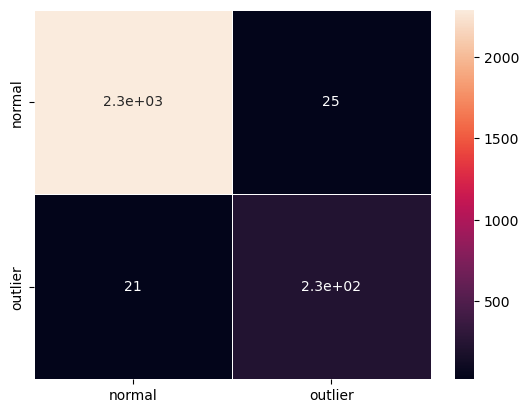

In [20]:
labels = data.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
acc = accuracy_score(y_outlier, y_pred)
prec = precision_score(y_outlier, y_pred)
rec = recall_score(y_outlier, y_pred)
print('F1 score: {} -- Accuracy: {} -- Precision: {} -- Recall: {}'.format(f1, acc, prec, rec))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

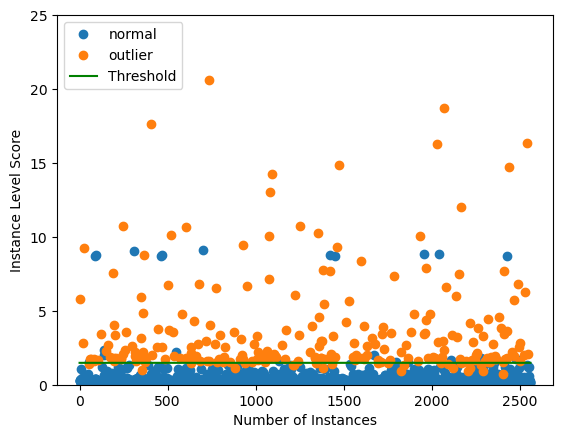

In [21]:
plot_instance_score(od_preds, y_outlier.astype(int), labels, od.threshold, ylim=(0, 25))